In [1]:
!pip3 install git+https://github.com/thilowrona/fatbox.git

  Cloning https://github.com/thilowrona/fatbox.git to /tmp/pip-req-build-u7oedckw
  Running command git clone -q https://github.com/thilowrona/fatbox.git /tmp/pip-req-build-u7oedckw
  Cloning https://github.com/ulikoehler/cv_algorithms.git to /tmp/pip-install-gvdgx199/cv-algorithms_6b7e4690ec74408881343050be969a02
  Running command git clone -q https://github.com/ulikoehler/cv_algorithms.git /tmp/pip-install-gvdgx199/cv-algorithms_6b7e4690ec74408881343050be969a02
     |████████████████████████████████| 167 kB 5.3 MB/s 
     |████████████████████████████████| 88.3 MB 103 kB/s 
     |████████████████████████████████| 232 kB 58.4 MB/s 
     |████████████████████████████████| 51 kB 7.7 MB/s 
     |████████████████████████████████| 1.1 MB 54.1 MB/s 
     |████████████████████████████████| 271 kB 54.7 MB/s 
     |████████████████████████████████| 144 kB 55.9 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
  Created wheel for fatbox: filename=fatbox-0.0.1-py3-none-any.whl size=2

In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1I2ct0IhTpFqWb2B9T-XPVysXolAeKD3R',
                                    dest_path='./map.png',
                                    unzip=False)

In [3]:
import numpy as np 
import networkx as nx
import pickle
import cv2
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial import distance_matrix
from skimage import feature, morphology, filters
from sklearn.preprocessing import normalize

from sys import stdout

from fatbox.preprocessing import *
from fatbox.metrics import *
from fatbox.edits import *
from fatbox.plots import *

In [4]:
img = Image.open('map.png').convert('L')
data = np.array(img)

data = 1-(data-np.min(data))/(np.max(data)-np.min(data))

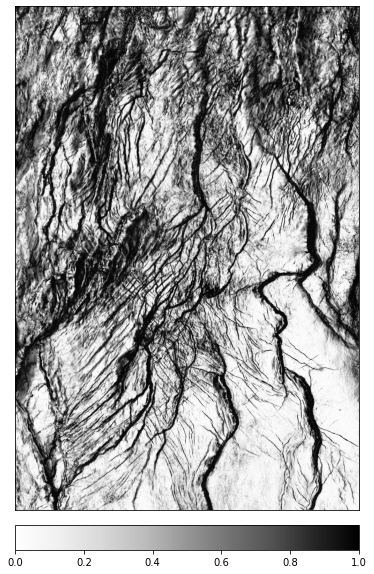

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(data, cmap='Greys', vmin=0)
plt.xticks([])
plt.yticks([])
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size="5%", pad=0.2, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im, cax=cax, orientation="horizontal")
plt.show()

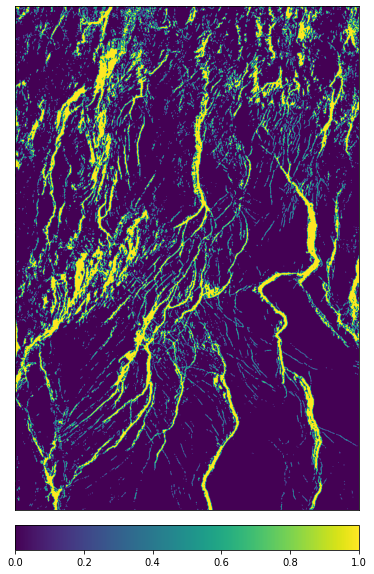

In [6]:
threshold = simple_threshold_binary(data, 0.9)

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(threshold, vmin=0, vmax=1)
plt.xticks([])
plt.yticks([])
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size="5%", pad=0.2, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im, cax=cax, orientation="horizontal")
plt.show()

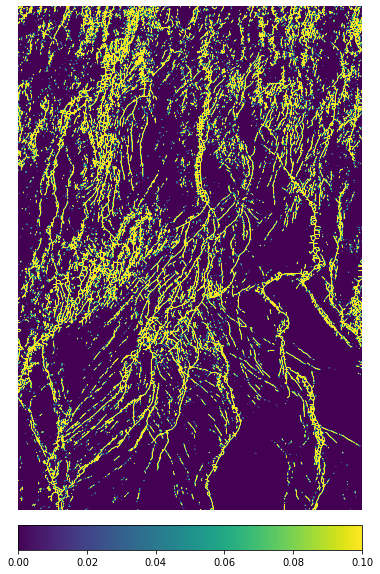

In [7]:
skeleton = skeleton_guo_hall(threshold)

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(skeleton, vmin=0, vmax=0.1)
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size="5%", pad=0.2, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im, cax=cax, orientation="horizontal")
plt.show()

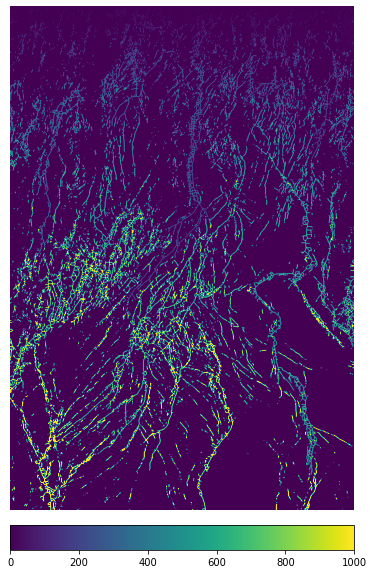

In [8]:
ret, markers = cv2.connectedComponents(skeleton)

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(markers, vmin=0, vmax=1000)
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size="5%", pad=0.2, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im, cax=cax, orientation="horizontal")
plt.show()

In [9]:
G = nx.Graph()

node = 0
for comp in tqdm(range(1,ret)):

    points = np.transpose(np.vstack((np.where(markers==comp))))    
    
    for point in points:
        G.add_node(node)
        G.nodes[node]['pos'] = (point[1], point[0])
        G.nodes[node]['component'] = comp
        node += 1  

100%|██████████| 6613/6613 [02:04<00:00, 53.24it/s]


In [10]:
for comp in tqdm(range(1,ret)): 
    
    points = [G.nodes[node]['pos'] for node in G if G.nodes[node]['component']==comp]
    nodes  = [node for node in G if G.nodes[node]['component']==comp]

    dm = distance_matrix(points, points)  
    
    
    for n in range(len(points)):
        # print(n)
        for m in range(len(points)):
            if dm[n,m]<1.5 and n != m:
                G.add_edge(nodes[n],nodes[m])

100%|██████████| 6613/6613 [35:33<00:00,  3.10it/s]


AttributeError: ignored

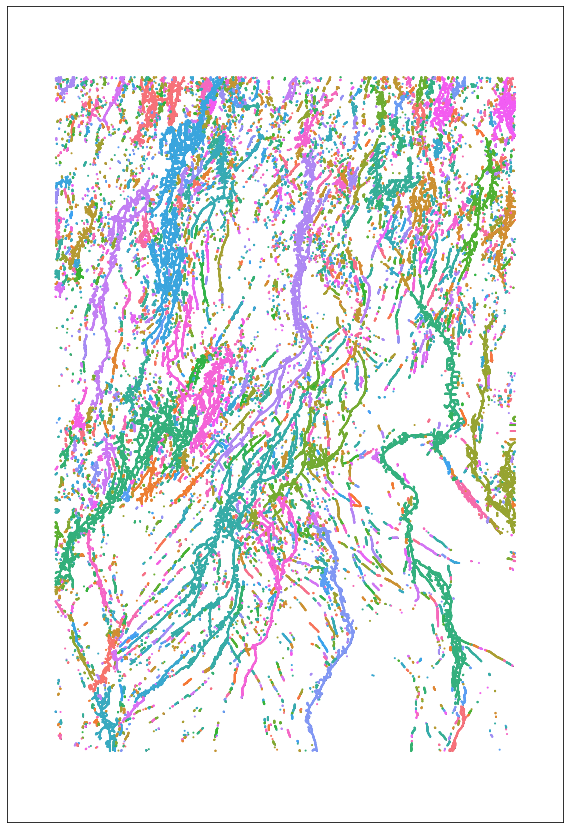

In [12]:
G = label_components(G)

fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.imshow(np.zeros_like(data), 'gray_r', vmin=0)
plot_components(G, labels=False, node_size=1, ax=ax)
ax.set_xlim(0,data.shape[1])
ax.set_ylim(data.shape[0],0)
plt.show()

In [13]:
G = split_triple_junctions(G, 25)
G = label_components(G)

AttributeError: ignored

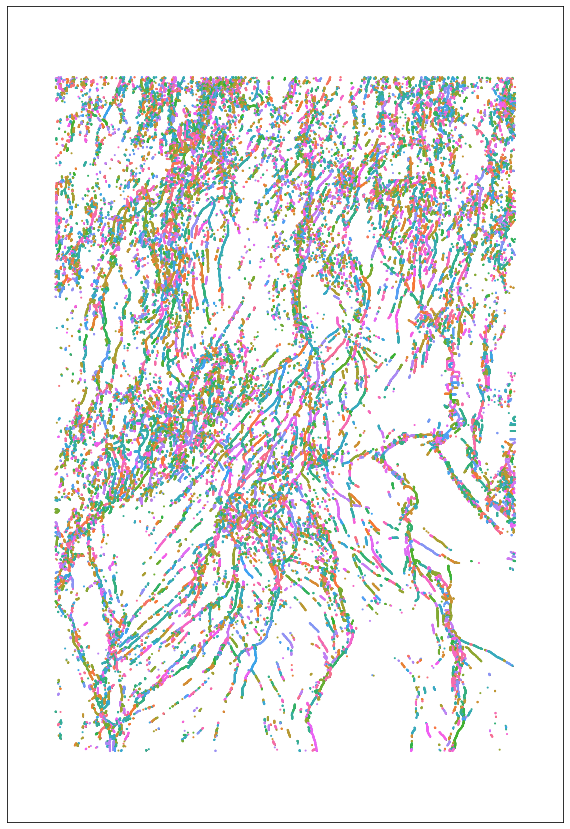

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.imshow(np.zeros_like(data), 'gray_r', vmin=0)
plot_components(G, labels=False, node_size=1, ax=ax)
ax.set_xlim(0,data.shape[1])
ax.set_ylim(data.shape[0],0)
plt.show()